In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty

import seaborn as sns

import folium



### Acceptable Signal Strengths


| Signal Strength | TL        | DR                                                                                                    | Required for                                |
|-----------------|-----------|-------------------------------------------------------------------------------------------------------|---------------------------------------------|
| -30 dBm         | Amazing   | Max achievable signal strength. The client can only be a few feet from the AP to achieve this.        | Not typical or desirable in the real world. |
| -67 dBm         | Very Good | Minimum signal strength for applications that require very reliable, timely delivery of data packets. | VoIP/VoWiFi, streaming video                |
| -70 dBm         | Okay      | Minimum signal strength for reliable packet delivery.                                                 | Email, web.                                 |
| -80 dBm         | Not Good  | Minimum signal strength for basic connectivity. Packet delivery may be unreliable                     | N/A                                         |
| -90 dBm         | Unusable  | Approaching or drowning in the noise floor. Any functionality is highly unlikely.                     | N/A                                         |

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [3]:
print()

## Exploration des données BS sur les set de train et de test

### Aperçu des stations

In [4]:
df_mess_train[0:10]

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.000000,1.463553e+12,39.732045,-104.973651
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,1.0,-123.333333,1.463555e+12,39.704887,-105.016392
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,1.0,-129.666667,1.463555e+12,39.612745,-105.008827
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,1.0,-123.666667,1.463555e+12,39.654682,-105.043685
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,1.0,-133.000000,1.463555e+12,39.495225,-105.053109


In [5]:
pos_train[0:10]

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940
5,39.730417,-104.968940
6,39.693102,-105.006995
7,39.693102,-105.006995
8,39.693102,-105.006995
9,39.693102,-105.006995


In [6]:
df_mess_train[df_mess_train.did == 473335.0]

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
127,573cbc43f0fe6e735adabf38,3558,473335.0,1.0,-122.000000,1.463598e+12,39.810055,-105.010413
128,573cbc43f0fe6e735adabf38,3559,473335.0,1.0,-124.000000,1.463598e+12,39.800079,-104.999947
131,573cc276864fce1a9a7dd272,2846,473335.0,0.0,-127.000000,1.463600e+12,39.666188,-105.077530
132,573cc3e1864fce1a9a7e8cac,2841,473335.0,1.0,-108.000000,1.463600e+12,39.617794,-104.954917
133,573cc3e1864fce1a9a7e8cac,3526,473335.0,2.0,-137.000000,1.463600e+12,39.677251,-104.952721
134,573cc5753e952e1912f0d833,2841,473335.0,1.0,-131.333333,1.463601e+12,39.617794,-104.954917
143,573d44aa3e952e19123052b2,2841,473335.0,0.5,-95.000000,1.463633e+12,39.617794,-104.954917


In [7]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


### BSID du train et du test set

In [8]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [9]:
print("|Nombre total de stations             |", len(listOfBs))
print("|Nombre de stations dans le train set |", len(np.unique(df_mess_train['bsid'])))
print("|Nombre de stations dans le test set  |", len(np.unique(df_mess_test['bsid'])))

|Nombre total de stations             | 259
|Nombre de stations dans le train set | 251
|Nombre de stations dans le test set  | 168


##### Conclusion: 8 stations du test set n'apparaissent pas dans le train set.

In [10]:
print("|Nombre d'observations (objid) dans le train set |", len(np.unique(df_mess_train['objid'])))
print("|Nombre d'observations (objid) dans le test set  |", len(np.unique(df_mess_test['objid'])))
print("|Taille du train set                             |", len(df_mess_train))
print("|Taille du test set                              |", len(df_mess_test))

|Nombre d'observations (objid) dans le train set | 6068
|Nombre d'observations (objid) dans le test set  | 5294
|Taille du train set                             | 39250
|Taille du test set                              | 29286


In [11]:
29 / 5.3

5.471698113207547

##### Conclusion: environ 6 mesures par observation

### Comment sont répartis les niveaux de signal reçu ?

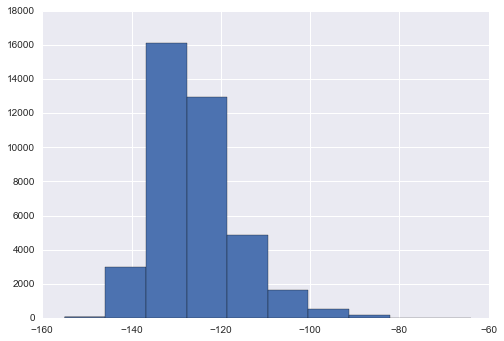

In [12]:
df_mess_train['rssi'].hist()

### Comment sont réparties les stations du train set et du test set ?

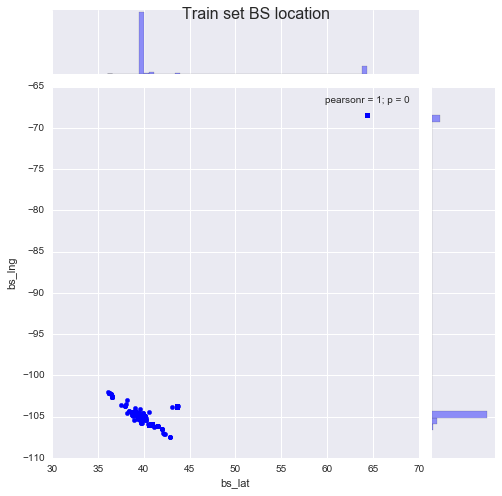

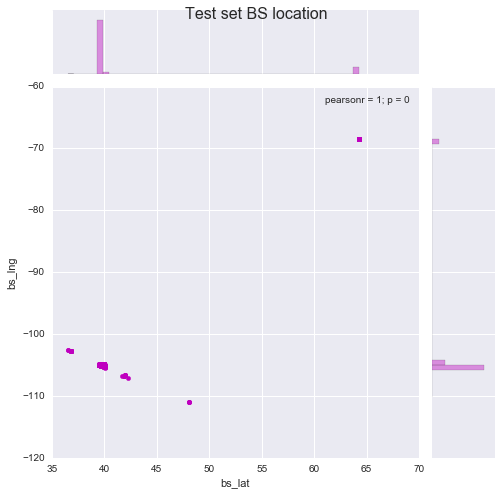

In [13]:
g = sns.jointplot("bs_lat", "bs_lng", data=df_mess_train, color="b", size=7)
g.fig.suptitle("Train set BS location", fontsize=16) 
g = sns.jointplot("bs_lat", "bs_lng", data=df_mess_test, color="m", size=7)
g.fig.suptitle("Test set BS location", fontsize=16) 

##### Les stations semblent être regroupées dans le même zone géographique, à quelques exceptions.

### Affichons sur une carte l'emplacement d'un échantillons de stations du train set pour mieux percevoir l'effet observé plus haut.

In [14]:
my_map = folium.Map()

count = 0
for index, row in df_mess_train.iterrows():
    # Display only 1 on 5000 station
    if index % 5000 == 1:
        folium.Marker([row['bs_lat'],row['bs_lng']]).add_to(my_map)
    
    # But display all stations on atypic places
    if row['bs_lat'] > 62 and count < 2:
        count += 1
        folium.Marker([row['bs_lat'],row['bs_lng']], popup="Atypic", icon=folium.Icon(color='red')).add_to(my_map)
        

In [15]:
# Final rendering
my_map

#### Les stations sont regroupées dans le même zone géographique, à quelques exceptions. Observons désormais l'emplacement des devices associés.

## Exploration de l'emplacement des devices (pos_train)

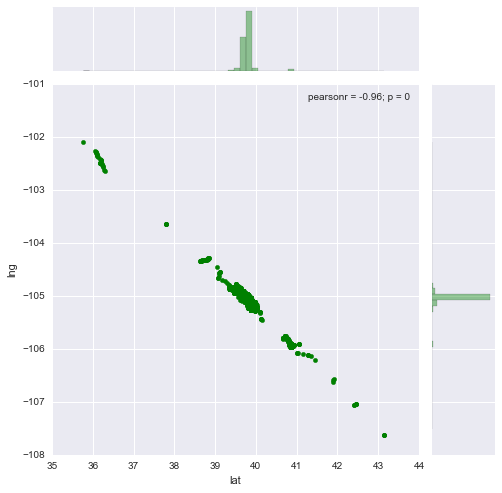

In [16]:
g = sns.jointplot("lat", "lng", data=pos_train, color="g", size=7)

On constate que ces points sont regroupés. A la lumière des coordonnées des BS, cela nous pousse à éliminer les points des BS qui nous semblent atypiques.

In [17]:
my_map = folium.Map()

count = 0
for index, row in pos_train.iterrows():
    # Display only 1 on 500 station
    if index % 500 == 1:
        folium.Marker([row['lat'],row['lng']], icon=folium.Icon(color='green')).add_to(my_map)

In [18]:
my_map

##### Conclusion: l'ensemble des devices est regroupé dans la même zone géographique. En particulier, aucun d'entre eux n'est situé dans la zone "atypique" où se trouvent quelques stations. 

# Préparation des données d'entraînement

L'idée est d'effectuer les traitements suivants: 
1. Rajout d'une colonne qui donne la distance entre la BS et le Device.
2. Transformation du niveau de signal en une grandeur équivalente à une distance.

In [118]:
df_merge = pd.concat([df_mess_train, pos_train], axis=1)

In [119]:
def f(x):
    return vincenty((x[6], x[7]), (x[8], x[9])).miles

In [120]:
# Adding vincenty distance from devices to base stations
df_merge['dist'] = df_merge.apply(f, axis=1)

In [121]:
# d = 10 ^ ((P-Rssi) / 10n) (n ranges from 2 to 4)
# https://forums.estimote.com/t/use-rssi-measure-the-distance/3665
# The idea is to create a column proportional to distance.
df_merge['d_rssi'] = 10 ** ((30 - df_merge['rssi']) / 100)

In [122]:
df_merge.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,dist,d_rssi
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343,255.229467,36.961027
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954,705.754365,7.134208
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.016510,8.709636
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463,1.400517,32.359366
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440,2.911849,37.439784
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730,6.107650,42.169650
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289,2254.742248,70.794578


## Affichons la répartitions des distances BS - Devices

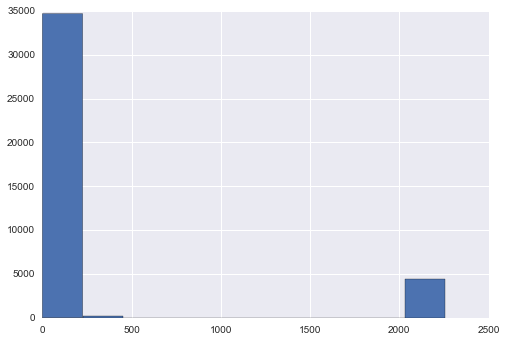

In [123]:
df_merge['dist'].hist()

### On retrouve les distances aberrantes observées auparavant.

In [124]:
df_merge['dist'].quantile(0.88)

20.673322853507102

### Aperçu des positions géographiques des devices

## "Clean" des données d'apprentissage

In [125]:
df_merge_clean = df_merge[df_merge['dist'] < 100]

In [126]:
df_merge_not_clean = df_merge[df_merge['dist'] >= 100]

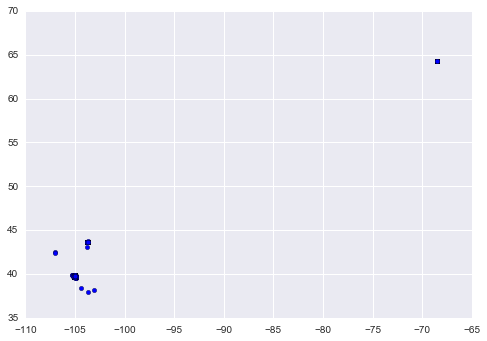

In [127]:
plt.scatter(df_merge_not_clean.bs_lng, df_merge_not_clean.bs_lat) # plotting t,a separately 
plt.scatter(df_merge_not_clean.lng, df_merge_not_clean.lat) # plotting t,b separately 

In [128]:
df_merge_not_clean['bsid'].unique()

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  1156,
        1187,  2293,  4959, 10148, 10999,  1661,  8449,  4156,  4129,
        1743,  4987,  1772,  1796,  2707,  2943,  4123, 11951,  9784,
        1092,  7508,  3848,  2803,  2808,  3630,  2800,  3933,  3501,
        4013,  1443,  1854,  7248])

In [129]:
print(len(df_merge_not_clean['objid'].unique()),
len(df_merge_clean['objid'].unique()))

1897 5870


In [130]:
len(np.intersect1d(df_merge_not_clean['objid'].unique(), df_merge_clean['objid'].unique()))

1699

### Le graphique ci-dessous affiche la relation en le niveau de signal (rssi) et la distance

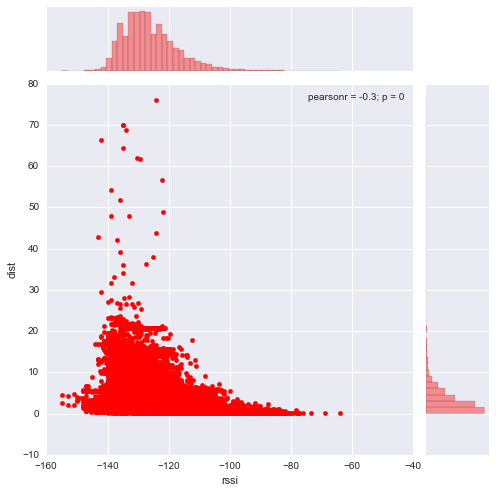

In [131]:
g = sns.jointplot("rssi", "dist", data=df_merge_clean, color="r", size=7)

In [132]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


### Le graphique ci-dessous affiche la relation en le niveau de signal converti en grandeur métrique (d_rssi) et la distance

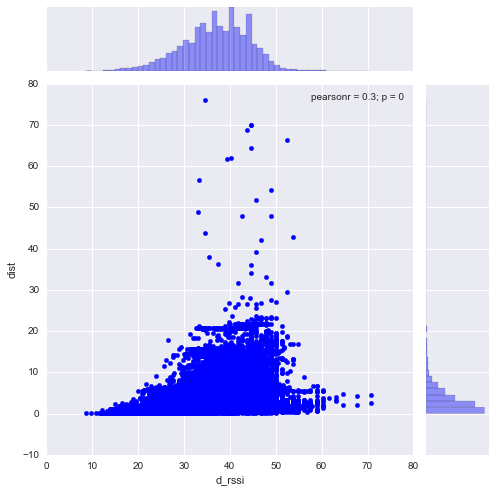

In [133]:
g = sns.jointplot("d_rssi", "dist", data=df_merge_clean, color="b", size=7)

### Certains points semblent encore atypiques ...

## Création d'un set d'entraînement

Nous proposons d'utiliser l'inverse de d_rssi (dont l'ordre de grandeur est une distance) afin de représenter par des 0 les valeurs qui correspondent à des stations "éloignées".

In [136]:
# Feature Matrix construction 

def feat_mat_const(df, bs_list, val='inv_d_rssi', fillna=0.0):
    '''
    feat_mat_const() pivots df to use "bs_list" list as a column and returns generated df.
    Input:
    df: input df
    bs_list: list of columns
    val: the column from df we want to preserve
    fillna: the value to use to replace NaN (0.0 could not be wise)
    Output:
    A df with base station id as columns.
    '''
    df_feat0 = df.pivot(index='objid', columns='bsid', values=val)
    
    df_feat = pd.DataFrame(columns=listOfBs)
    
    for col in df_feat0.columns:
        df_feat[col] = df_feat0[col]
        
    df_feat = df_feat.fillna(fillna)
    
    return df_feat

In [137]:
# ground truth construction
def ground_truth_const(df_mess_train, pos_train):
    '''
    ground_truth_const() returns (latitude, longitude) from the observations
    corrsponding to objid
    '''

    temp1 = df_mess_train.copy()
    temp1[['lat', 'lng']] = pos_train
    
    temp2 = temp1.drop_duplicates('objid')[['lat', 'lng']]

    ground_truth_lat = np.array(temp2['lat'])
    ground_truth_lng = np.array(temp2['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [192]:
np.max(df_merge['d_rssi'])

70.794578438413808

In [193]:
df_y_train = df_merge.drop_duplicates('objid')[['lat', 'lng']]
print("|Nombre d'observations sur le train |", len(df_y_train))

|Nombre d'observations sur le train | 6068


In [157]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

In [159]:
# Evaluate result

def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [187]:

# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [262]:
df_train = df_merge.copy()
df_train['inv_d_rssi'] = 1 / df_merge['d_rssi'].values
df_train['is_rssi'] = 1 
df_train['level_rssi'] = pd.cut(df_train.rssi, [-160, -90, -80, -70, -67, -30, 0], right=True, labels=[1,2,3,4,5,6])
df_train['level_rssi'] = df_train['level_rssi'].astype(int)

In [267]:
df_train.rssi

0       -121.500000
1       -125.000000
2       -134.000000
3       -132.000000
4       -120.000000
5       -100.000000
6       -123.333333
7       -129.666667
8       -123.666667
9       -133.000000
10      -141.000000
11      -116.666667
12      -120.333333
13      -138.000000
14      -138.000000
15      -131.000000
16      -120.000000
17      -132.000000
18      -125.666667
19      -137.500000
20      -108.000000
21      -125.500000
22      -117.000000
23      -130.000000
24      -136.333333
25      -121.500000
26      -123.000000
27      -136.000000
28      -108.666667
29      -135.500000
            ...    
39220   -122.333333
39221   -119.666667
39222    -90.666667
39223   -126.500000
39224   -128.000000
39225   -124.000000
39226   -132.000000
39227   -117.000000
39228   -125.500000
39229   -123.000000
39230   -132.333333
39231   -130.000000
39232   -137.000000
39233   -122.000000
39234   -147.000000
39235   -112.333333
39236   -131.000000
39237   -130.500000
39238   -132.000000


In [263]:
# df_X_train = feat_mat_const(df_train, listOfBs, val='d_rssi', fillna=71)
#df_X_train = feat_mat_const(df_train, listOfBs, val='is_rssi')
df_X_train = feat_mat_const(df_train, listOfBs, val='level_rssi')
print("|Nombre de messages sur le train |", len(df_X_train))

|Nombre de messages sur le train | 6068


In [264]:
df_X_train.describe()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
count,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.0,...,6068.0,6068.0,6068.0,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000
mean,0.000165,0.000165,0.000165,0.000494,0.001318,0.014008,0.011042,0.005274,0.000165,0.0,...,0.0,0.0,0.0,0.001318,0.000330,0.055043,0.098385,0.000165,0.045485,0.000165
std,0.012837,0.012837,0.012837,0.022231,0.036289,0.117533,0.104506,0.072434,0.012837,0.0,...,0.0,0.0,0.0,0.036289,0.018153,0.228804,0.297859,0.012837,0.209171,0.012837
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.0,0.0,0.0,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000


In [260]:
# Cross validation

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn import preprocessing

reg = tree.DecisionTreeRegressor()

# Pas d'intérêt à centrer réduire
#X_train = preprocessing.scale(df_X_train.values)

y_pred_lng = cross_val_predict(reg, X_train, ground_truth_lng, cv=10, n_jobs=-1)
y_pred_lat = cross_val_predict(reg, X_train, ground_truth_lat, cv=10, n_jobs=-1)

4571.8071505564685

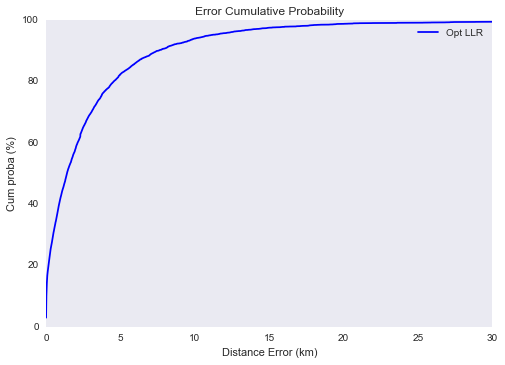

In [261]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

# Plot error distribution

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

# Error criterion

np.percentile(err_vec, 80)

In [ ]:
# Construct test prediction

df_mess_test.head()

df_feat_test = feat_mat_const(df_mess_test, listOfBs)

y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])

test_res.to_csv('pred_pos_test_list.csv', index=False)

test_res.head()